# Цель
Набор данных был взят с конкурса https://retailhero.ai/c/uplift_modeling/overview.

Попробовать предсказать, использую информацию о купленых продуктах, каким клиентам стоит отправлять SMS сообщения. 
Для эксперимента попробуем модели для обработки текста, как буд-то купленные продукты это слова сказанные клиентом
Метрика качества будет uplift_at_k из библиотеки sklift.metrics

# Описани используемых полей

## clients.csv
информация о всех клиентах.
поля:
- `client_id` - идентификатор клиента
- `first_issue_date` - дата предложения
- `first_redeem_date` - дата когда воспользовались предложением
- `age` - возраст
- `gender` - пол

## products.csv
информация о производители продукта
поля:
- `product_id` - идентификатор продука
- `brand_id` - идентфикатор бренда

## purchases.csv
информация о транзакциях клиента
поля:
- `client_id` - идентификатор клиента
- `transaction_id` - идентфикатор транзакции
- `transaction_datetime` - время транзакции
- `regular_points_received`, `express_points_received`, `regular_points_spent`, `express_points_spent` - что-то о балах
- `purchase_sum` - сумма чека
- `store_id` - идентификатор магазина где была совершена транзакция
- `product_id` - идентификатор купленного продукта
- `product_quantity` - количество купленного продукта

## uplift_train.csv
информация о клиентах на которых предлагается обучиться
поля:
- `client_id` - идентификатор клиента
- `treatment_flg` - было ли оказано воздействие на клиента(отправлено ли СМС)
- `target` - совершил ли клиент покупку


## hash_product_all.pkl
Сгенерирован на основе `products.csv` и `purchases.csv`. Содержит словарь где ключ это идентификатор пользователя, а значение - словарь купленых продуктов

## generated_features.pkl
Сгенерирован на основе `clients.csv` и `products.csv` содержит массив словарей с полями:
- `client_id` - идентификатор клиента
- `store_count` - количество магазинов в которых закупался клиент
- `product_type_count` - количество типов купленных продуктов
- `transaction_count` - количество транзакций
- `days_sum` - количество дней между первой и последней транзакцией
- `days_mean` - среднее
- `days_std` - отклонение
- `days_median` - медиана
- `product_quantity_sum` - сколько всего в штуках куплено продуктов за всю историю
- `product_quantity_mean` - среднее
- `product_quantity_std` - отклонение 
- `roduct_quantity_median` - медиана
- `purchase_sum_sum` - сумма потраченных денег по всем транзакциям
- `purchase_sum_mean` - среднее
- `purchase_sum_std` - отклонение
- `purchase_sum_median` - медиана
- `trn_sum_from_iss_sum`
- `trn_sum_from_iss_mean`
- `trn_sum_from_iss_std`
- `trn_sum_from_iss_median`
- `trn_sum_from_red_sum`
- `trn_sum_from_red_mean`
- `trn_sum_from_red_std`
- `trn_sum_from_red_median`
- `regular_points_received_sum`
- `regular_points_received_mean`
- `regular_points_received_std`
- `regular_points_received_median`
- `express_points_received_sum`
- `express_points_received_mean`
- `express_points_received_std`
- `express_points_received_median`
- `regular_points_spent_sum`
- `regular_points_spent_mean`
- `regular_points_spent_std`
- `regular_points_spent_median`
- `express_points_spent_sum`
- `express_points_spent_mean`
- `express_points_spent_std`
- `express_points_spent_median`


In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#from collections import defaultdict, OrderedDict
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from datetime import datetime

%matplotlib inline

# Загрузка данных


In [2]:
def load_pkl(filename):
    with open(filename, 'rb') as pklfile:
        return pickle.load(pklfile)

In [3]:
# размеченные пользователи
data = pd.read_csv('data/uplift_train.csv', index_col='client_id')

In [4]:
# купленные пользователями продукты
products_of_client = load_pkl('data/hash_product_all.pkl')

In [5]:
# признаки для пользователей
clients = load_pkl('data/generated_features.pkl')
clients = pd.DataFrame(clients).set_index('client_id')

In [6]:
clients = pd.merge(
    clients,
    pd.read_csv('data/clients.csv', index_col='client_id'),
    left_index=True,
    right_index=True,
    how='outer'
)

In [7]:
# преобразуем дату в число дней от старта юникс эпохи
clients['first_issue_date'] = (pd.to_datetime(clients['first_issue_date']) - datetime(1970,1,1)).map(lambda x: x.days)
clients['first_redeem_date'] = (pd.to_datetime(clients['first_redeem_date']) - datetime(1970,1,1)).map(lambda x: x.days)
clients['issue_redeem_delay'] = clients['first_redeem_date'] - clients['first_issue_date']

In [8]:
clients.isnull().sum()

store_count                            0
product_type_count                     0
transaction_count                      0
days_sum                               0
days_mean                           7707
days_std                           18785
days_median                         7707
product_quantity_sum                   0
product_quantity_mean                  0
product_quantity_std                 763
product_quantity_median                0
trn_sum_from_iss_sum                   0
trn_sum_from_iss_mean                  0
trn_sum_from_iss_std                 763
trn_sum_from_iss_median                0
trn_sum_from_red_sum                   0
trn_sum_from_red_mean             155798
trn_sum_from_red_std              172739
trn_sum_from_red_median           155798
regular_points_received_sum            0
regular_points_received_mean           0
regular_points_received_std         7707
regular_points_received_median         0
express_points_received_sum            0
express_points_r

In [9]:
# заполним нулями признаки в торых получилось Nan значение в результате, например, вычисления откланение по одному единственному значению
clients.fillna(0, inplace=True)

In [10]:
clients.head()

,store_count,product_type_count,transaction_count,days_sum,days_mean,days_std,days_median,product_quantity_sum,product_quantity_mean,product_quantity_std,...,express_points_spent_median,purchase_sum_sum,purchase_sum_mean,purchase_sum_std,purchase_sum_median,first_issue_date,first_redeem_date,age,gender,issue_redeem_delay
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,3,46,4,103,34.0,41.0,15.0,54.0,1.038462,0.558764,...,0.0,2803.00,700.750000,258.000484,688.5,17383,17535.0,45,U,152.0
000036f903,5,96,32,108,3.0,2.0,3.0,169.0,1.043210,0.526901,...,0.0,9805.00,306.406250,161.780987,267.0,17266,17279.0,72,F,13.0
000048b7a6,2,44,8,86,12.0,8.0,10.0,91.0,1.625000,0.843424,...,0.0,3772.00,471.500000,327.558065,400.5,17880,0.0,68,F,0.0
000073194a,1,68,17,110,6.0,6.0,4.0,127.0,1.548780,1.134775,...,0.0,9601.40,564.788235,410.462412,479.0,17309,17494.0,60,F,185.0
00007c7133,2,64,11,100,10.0,8.0,6.0,83.0,1.000000,0.584349,...,0.0,6719.84,610.894545,284.195416,551.0,17308,17896.0,67,U,588.0


# Посмотрим на данные

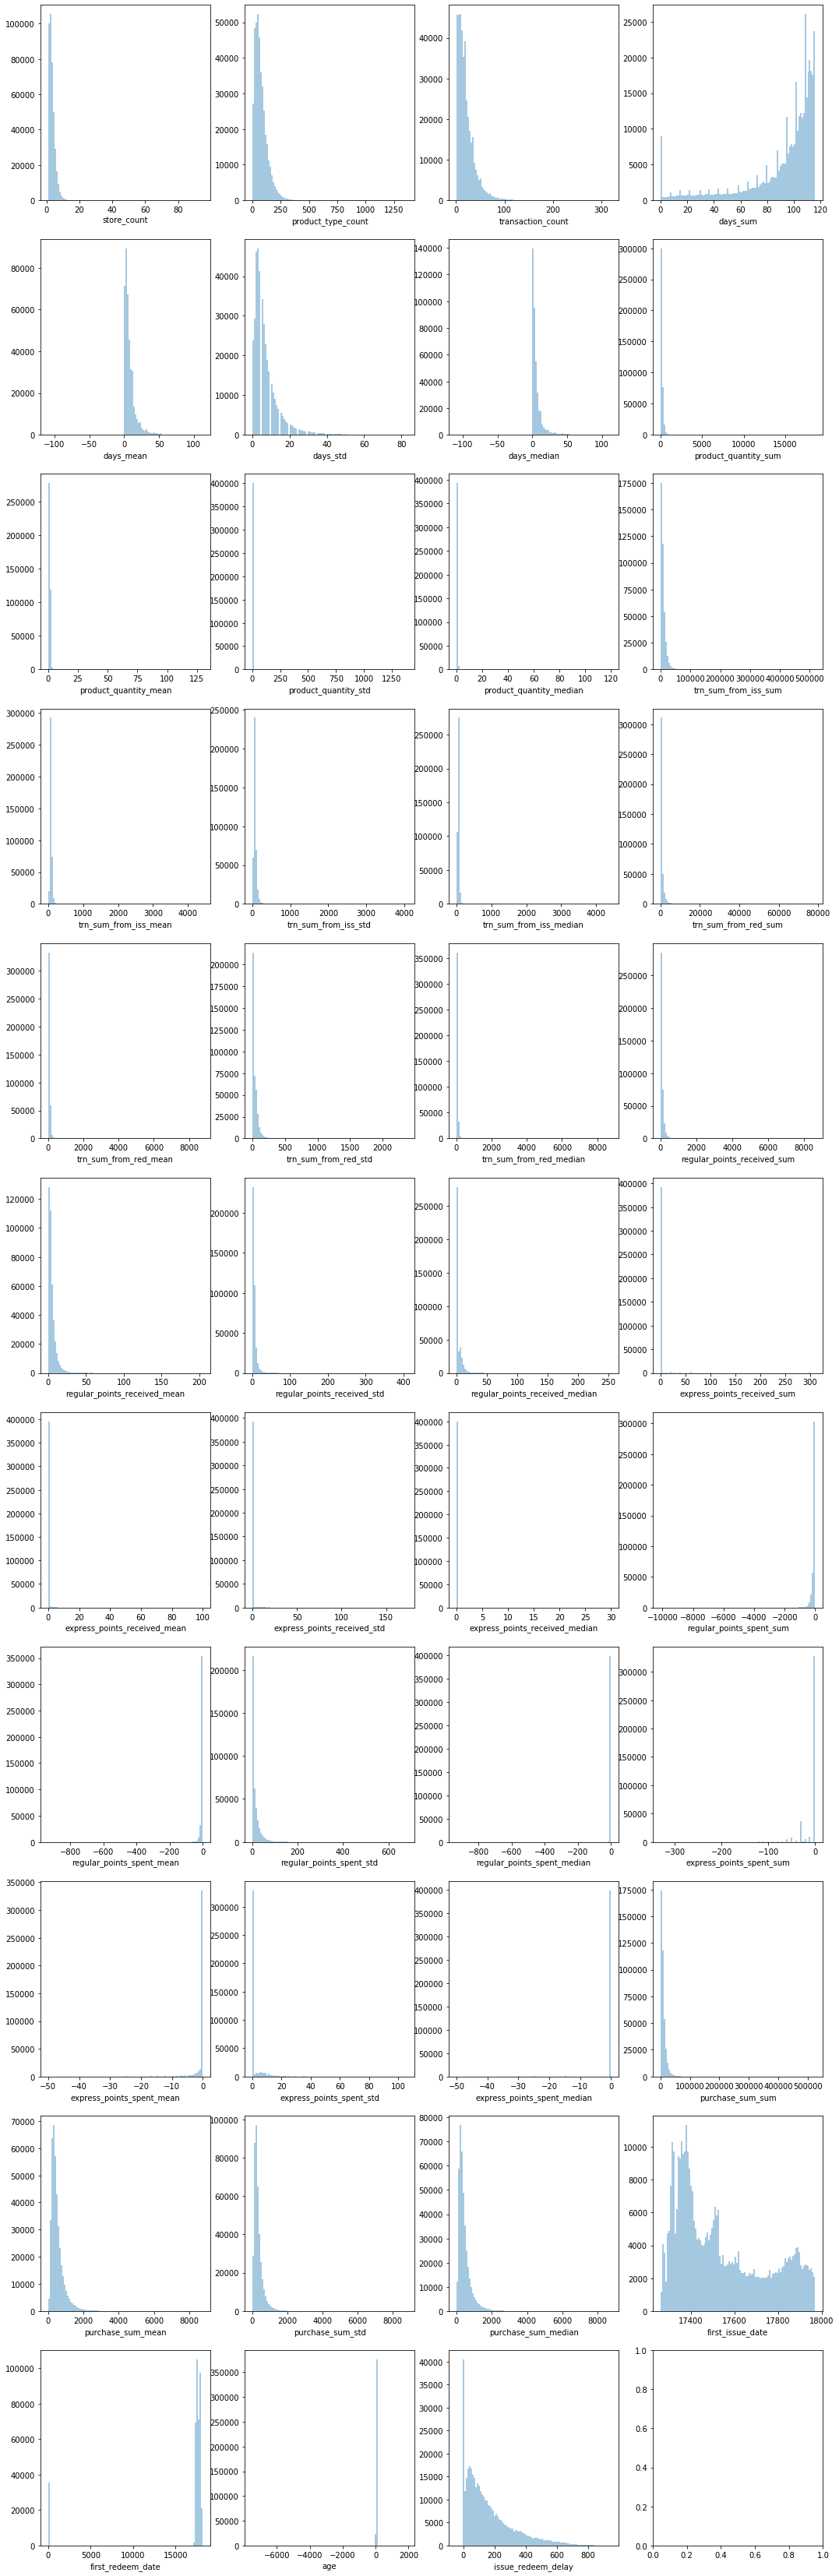

In [11]:
fig, axes = plt.subplots(nrows=11, ncols=4)
fig.set_size_inches(18, 60)

for column, ax in zip(filter(lambda x: True if clients[x].dtype in ['int64', 'float64'] else False, clients.columns), axes.flat):
    sns.distplot(clients[column], bins=100, ax=ax, kde=False)

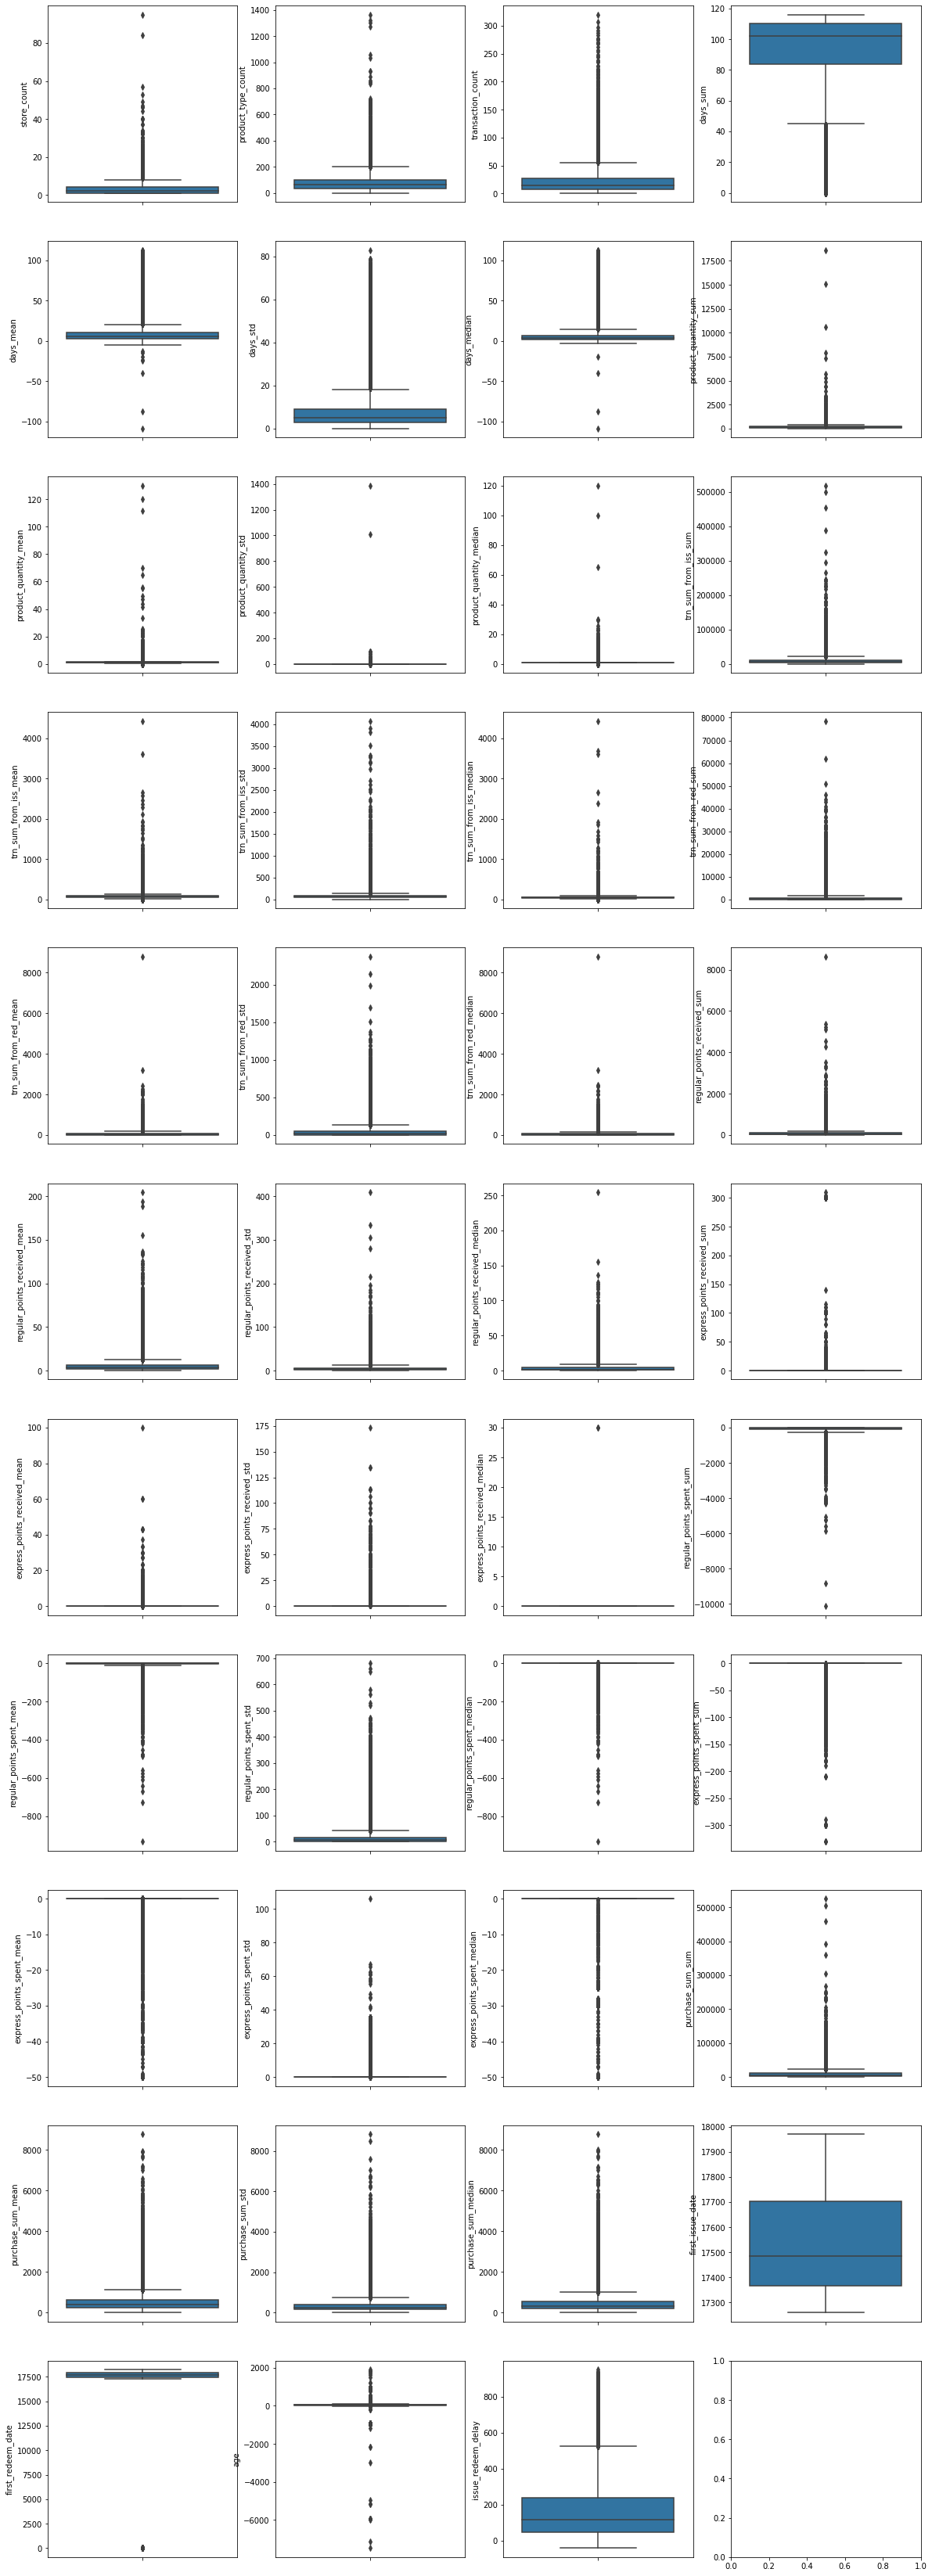

In [12]:
fig, axes = plt.subplots(nrows=11, ncols=4)
fig.set_size_inches(20, 60)

for column, ax in zip(filter(lambda x: True if clients[x].dtype in ['int64', 'float64'] else False, clients.columns), axes.flat):
    sns.boxplot(data=clients, y=column , ax=ax)

Выглядит не очень. Попробуем сделать что нибудь с выбросами

# Почистим выбросы

In [13]:
outlier_columns = list(clients.columns.drop('gender'))

In [14]:
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    if True in outlier_index.value_counts().index:
        return {'index':outlier_index,'Признак':col, 'Количество выбрасов': outlier_index.value_counts()[1], 'Доля в выборке': outlier_index.value_counts()[1]/len(outlier_index)}
    else:
        return {'Признак':col, 'Количество выбрасов': 0, 'Доля в выборке': 0}

In [15]:
values_for_bar = []
for column in outlier_columns:
    values_for_bar.append(
        outlier_detect_IQR(clients[outlier_columns], column, threshold=4)
    )

In [16]:
for f in values_for_bar:
    if 'index' in f:
        clients.loc[f['index'], f['Признак']] = clients[f['Признак']].median()

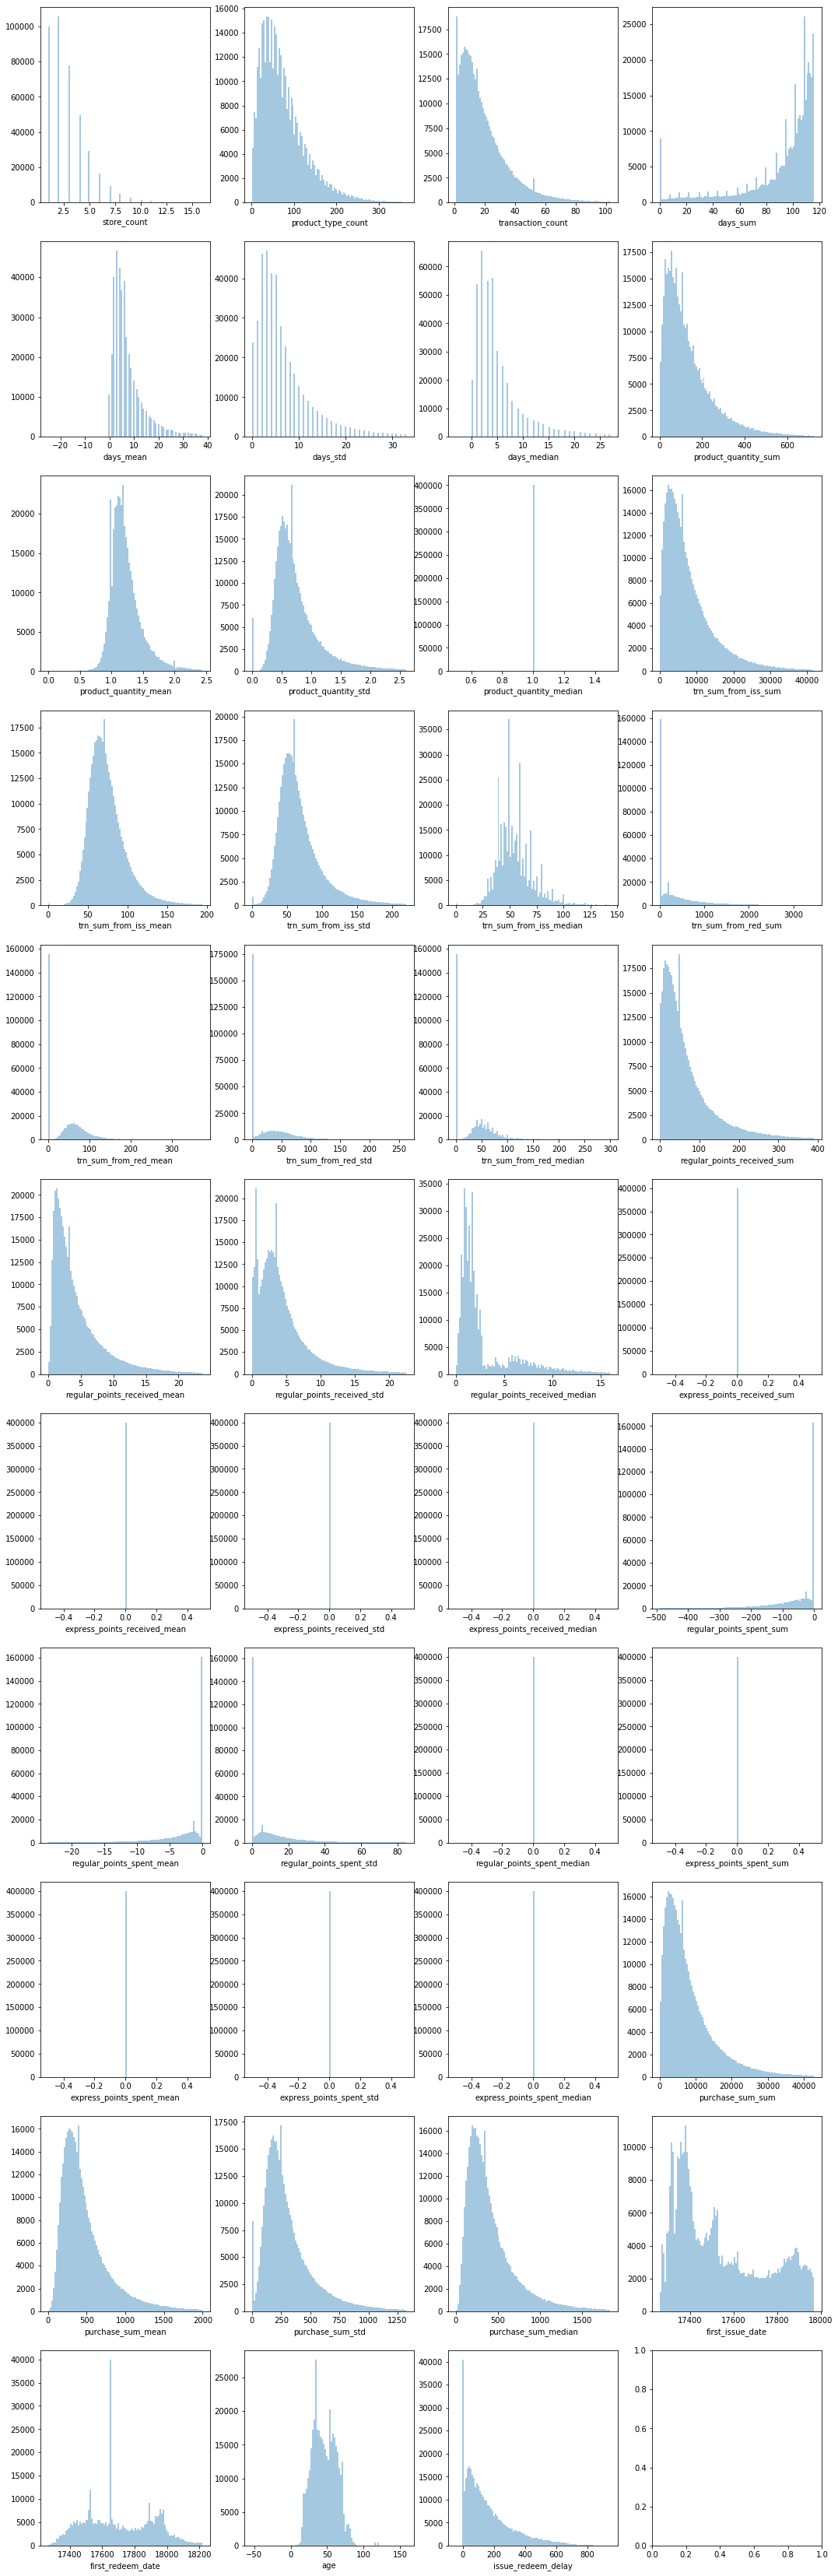

In [17]:
fig, axes = plt.subplots(nrows=11, ncols=4)
fig.set_size_inches(18, 60)

for column, ax in zip(filter(lambda x: True if clients[x].dtype in ['int64', 'float64'] else False, clients.columns), axes.flat):
    sns.distplot(clients[column], bins=100, ax=ax, kde=False)

In [18]:
clients.drop(columns=[
    'express_points_spent_median', 'express_points_spent_std',
    'express_points_spent_mean', 'express_points_spent_sum',
    'express_points_spent_median', 'express_points_received_median',
    'express_points_received_mean', 'express_points_received_std',
    'express_points_received_sum', 'product_quantity_median'
], inplace=True)


In [19]:
# соединим с разметкой пользователей
clients = pd.merge(
    clients,
    pd.read_csv('data/uplift_train.csv', index_col='client_id'),
    left_index=True,
    right_index=True,
    how='outer'
) 

# Построение моделей

## Предсказивания пола по продуктам

In [20]:
index_gender_u = clients[clients.gender == 'U'].index

In [21]:
index_gender_data = clients[(clients.gender == 'F') | (clients.gender == 'M')].index

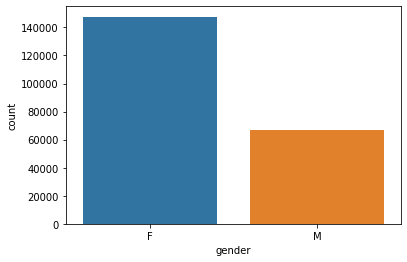

In [22]:
sns.countplot(x='gender', data=clients.loc[index_gender_data])

In [23]:
# выровняем количество объектов в классе выбросим случайным образом излишки из класса F

In [24]:
index_for_drop = np.random.choice(
    clients[clients.gender == 'F'].index,
    clients[clients.gender == 'F'].gender.count() - clients[clients.gender == 'M'].gender.count(),
    replace=False
)

In [25]:
index_gender_data = pd.Index(set(index_gender_data) - set(index_for_drop))

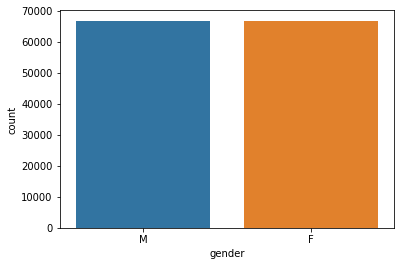

In [26]:
sns.countplot(x='gender', data=clients.loc[index_gender_data])

In [27]:
# разобьем на обучающую и тестовую выборку

In [28]:
x_index_train, x_index_test, y_index_train, y_index_test = train_test_split(
    index_gender_data,
    index_gender_data,
    random_state = 42
)

In [29]:
# Закадируем классы

In [30]:
gender_encoder = LabelEncoder()
gender_encoder.fit(clients.loc[y_index_train].gender)

LabelEncoder()

In [31]:
# Подготовим таблицу признаков. пользователи и продукты

In [32]:
x_train = []
for index in x_index_train:
    x_train.append(products_of_client[index])
y_train = gender_encoder.transform(clients.loc[y_index_train].gender.values)

x_test = []
for index in x_index_test:
    x_test.append(products_of_client[index])
y_test = gender_encoder.transform(clients.loc[y_index_test].gender.values)

x_u = []
for index in index_gender_u:
    x_u.append(products_of_client[index])

In [33]:
vectorizer = DictVectorizer()
x_vec_train = vectorizer.fit_transform(x_train)
x_vec_test = vectorizer.transform(x_test)
x_vec_u = vectorizer.transform(x_u)

tfidf = TfidfTransformer()
x_vec_train = tfidf.fit_transform(x_vec_train)
x_vec_test = tfidf.transform(x_vec_test)
x_vec_u = tfidf.transform(x_vec_u)

In [34]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True,  
    penalty='l2',
    random_state=42,
    n_jobs=4
)

In [35]:
logit_sgd.fit(x_vec_train, y_train)

train_class_predict = logit_sgd.predict(x_vec_train)
test_class_predict = logit_sgd.predict(x_vec_test)
u_class_predict = logit_sgd.predict(x_vec_u)

In [36]:
print(f'На трейне accuracy_score: {accuracy_score(train_class_predict, y_train)}')
print(f'На тесте accuracy_score: {accuracy_score(test_class_predict, y_test)}')

print(classification_report(logit_sgd.predict(x_vec_test), y_test))

На трейне accuracy_score: 0.7235006486378605
На тесте accuracy_score: 0.7021614177942761
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     17395
           1       0.68      0.72      0.70     16009

    accuracy                           0.70     33404
   macro avg       0.70      0.70      0.70     33404
weighted avg       0.70      0.70      0.70     33404



In [37]:
def plot_confusion_matrix(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted: True','Predicted: False'], index=['Actual: True','Actual: False'])
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False)

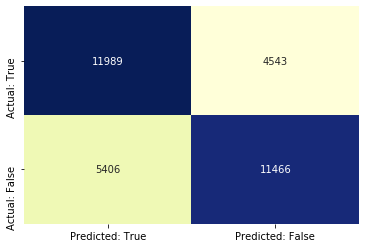

In [38]:
plot_confusion_matrix(y_test, test_class_predict)

In [39]:
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(actual, prob_prediction)
    auc_score = roc_auc_score(actual, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))

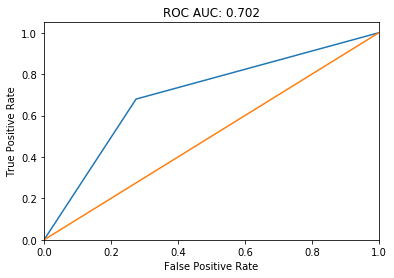

In [40]:
plot_roc_curve(test_class_predict, y_test)

In [41]:
# Посмотрим насколько модель уверена в предсказаниях

In [42]:
test_class_prob = logit_sgd.predict_proba(x_vec_test)
u_class_prob = logit_sgd.predict_proba(x_vec_u)

(array([ 170., 1389., 3691., 6070., 7121., 6315., 4414., 2654., 1333.,
         247.]),
 array([0.05014958, 0.14279329, 0.23543701, 0.32808072, 0.42072443,
        0.51336814, 0.60601185, 0.69865556, 0.79129927, 0.88394299,
        0.9765867 ]),
 <a list of 10 Patch objects>)

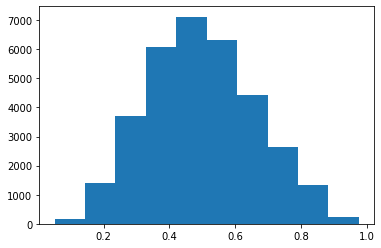

In [43]:
plt.hist(test_class_prob[:,1])

In [44]:
# возьмем только те предсказания в классах которых она уверена больше чем 0.65

In [45]:
index = (test_class_prob[:,1] > 0.65) | (test_class_prob[:,0] > 0.65)

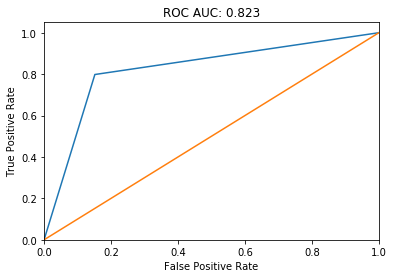

In [46]:
plot_roc_curve(test_class_predict[index], y_test[index])

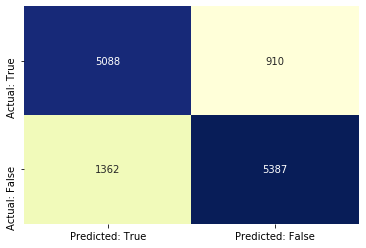

In [47]:
plot_confusion_matrix(y_test[index], test_class_predict[index])

In [48]:
# дополнить информацию по клиентам чей пол был не известен

In [49]:
u_index = (u_class_prob[:,1] > 0.65) | (u_class_prob[:,0] > 0.65)

In [50]:
new_gender = clients.loc[index_gender_u].gender.where(u_index, gender_encoder.inverse_transform(u_class_predict))

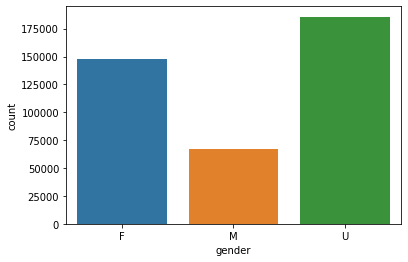

In [51]:
# было
sns.countplot(x='gender', data=clients, order=['F','M','U'])

In [52]:
clients.loc[new_gender.index, 'gender'] = new_gender

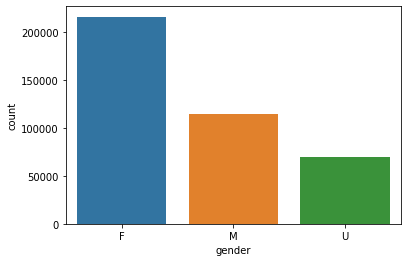

In [53]:
# Стало
sns.countplot(x='gender', data=clients, order=['F','M','U'])

## Попробуем посчитать uplift по продуктам

преобразуем целевой класс в:
 - 0 - не было покупки и не было воздействия 
 - 1 - не было покупки и было воздействие
 - 2 - не было воздействия и была покупка
 - 3 - было воздействие и была покупка


In [54]:
index_val = clients[clients.target.isnull()].index
index_data = clients[clients.target.notnull()].index

In [55]:
def get_new_class(row):
    if not row['treatment_flg'] and not row['target']:
        return 0
    if row['treatment_flg'] and not row['target']:
        return 1
    if not row['treatment_flg'] and row['target']:
        return 2
    if row['treatment_flg'] and row['target']:
        return 3

In [56]:
clients['target_new'] = clients.loc[index_data].apply(get_new_class, axis=1)

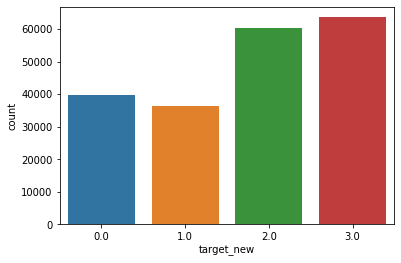

In [57]:
sns.countplot(x='target_new', data=clients.loc[index_data])

In [58]:
# Выровняем классы
min_count = clients[clients.target_new == 1].shape[0]

index_choise = list(np.random.choice(
    clients[clients.target_new == 0].index,
    min_count,
    replace=False
))

index_choise+= list(clients[clients.target_new == 1].index)

index_choise += list(np.random.choice(
    clients[clients.target_new == 2].index,
    min_count,
    replace=False
))

index_choise += list(np.random.choice(
    clients[clients.target_new == 3].index,
    min_count,
    replace=False
))

In [59]:
index_data = pd.Index(index_choise)

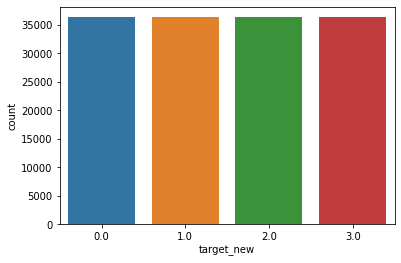

In [60]:
sns.countplot(x='target_new', data=clients.loc[index_data])

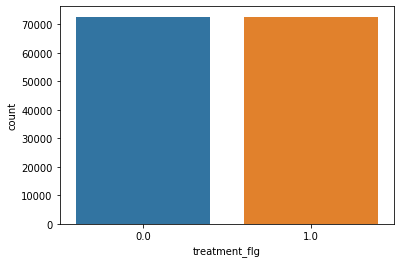

In [61]:
sns.countplot(x='treatment_flg', data=clients.loc[index_data])

In [62]:
# разобьем выборку на обучающую и тестовую

In [63]:
x_index_train, x_index_test, y_index_train, y_index_test = train_test_split(index_data, index_data, random_state=42)

In [64]:
x_train = []
for index in x_index_train:
    x_train.append(products_of_client[index])
y_train = clients.loc[y_index_train].target_new.values

x_test = []
for index in x_index_test:
    x_test.append(products_of_client[index])
y_test = clients.loc[y_index_test].target_new.values

In [65]:
vectorizer = DictVectorizer()
x_vec_train = vectorizer.fit_transform(x_train)
x_vec_test = vectorizer.transform(x_test)


tfidf = TfidfTransformer()
x_vec_train = tfidf.fit_transform(x_vec_train)
x_vec_test = tfidf.transform(x_vec_test)

In [66]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=50, 
    penalty='l2',
    random_state=42,
    max_iter=2000,
    n_jobs=4
)

In [67]:
logit_sgd.fit(x_vec_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=2000,
              n_iter_no_change=50, n_jobs=4, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [68]:
train_proba = logit_sgd.predict_proba(x_vec_train)
test_proba = logit_sgd.predict_proba(x_vec_test)

In [69]:
print(classification_report(logit_sgd.predict(x_vec_test), y_test))

              precision    recall  f1-score   support

         0.0       0.31      0.31      0.31      9290
         1.0       0.34      0.31      0.32      9921
         2.0       0.32      0.32      0.32      9142
         3.0       0.27      0.31      0.29      7989

    accuracy                           0.31     36342
   macro avg       0.31      0.31      0.31     36342
weighted avg       0.31      0.31      0.31     36342



In [70]:
print(f'На трейне: {uplift_at_k(y_true=clients.loc[x_index_train].target, uplift=train_proba[:,3], treatment=clients.loc[x_index_train].treatment_flg, k=0.3)}')

На трейне: 0.0648538448421907


In [71]:
print(f'На тесте: {uplift_at_k(y_true=clients.loc[x_index_test].target, uplift=test_proba[:,3], treatment=clients.loc[x_index_test].treatment_flg, k=0.3)}')

На тесте: 0.009729048493765768


# Результат

Используя информацию о копленых продуктах можно не плохо восстановить пол клиента, а предсказания совершит ли клиент покупку если ему будет отправлено смс удалось не очень.